In [49]:
import sys
sys.path.append('c://users/melvi/appdata/local/programs/python/python36/lib/site-packages')
import wordcloud
import warnings
warnings.filterwarnings("ignore")

import sqlite3
import pandas as pd
import numpy as np
import nltk
import string
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import TfidfVectorizer

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import confusion_matrix
from sklearn import metrics
from sklearn.metrics import roc_curve, auc
from nltk.stem.porter import PorterStemmer

import re
import string
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.stem.wordnet import WordNetLemmatizer

from gensim.models import Word2Vec
from gensim.models import KeyedVectors
import pickle



In [50]:
conn = sqlite3.connect('final.sqlite')
c=conn.cursor()
conn.text_factory = str
final=pd.read_sql_query(""" SELECT * FROM Reviews  """, conn) 

In [51]:
final.to_sql('Reviews', conn,  schema=None, if_exists='replace', index=True, index_label=None, chunksize=None, dtype=None)
# Sorting data based on time
final["Time"] = pd.to_datetime(final["Time"], unit = "s")
final= final.sort_values(by = "Time")

In [52]:
x = final['CleanedText'].values

In [53]:
def n_neighbour(vectors , n):
    distance = []
    for point in vectors:
        temp = np.sort(np.sum((vectors-point)**2,axis=1),axis=None)
        distance.append(temp[n])
    return np.sqrt(np.array(distance))

In [54]:
def dbscan(epsilon, samples, Data):
    from sklearn.cluster import DBSCAN
    db = DBSCAN(eps=epsilon, min_samples=samples, n_jobs=-1).fit(Data)
    
    # Number of clusters in labels, ignoring noise(-1) if present.
    n_clusters = len(set(db.labels_))
    print("Number of clusters for MinPts = %d and Epsilon = %f is : %d "%(samples,epsilon,n_clusters))
    print("Labels(-1 is for Noise) : ",set(db.labels_))
    print()
    return db

In [55]:
list_of_sent=[]
#for sent in final_40k['Text'].values:
def cleanhtml(sentence): #function to clean the word of any html-tags
    cleanr = re.compile('<.*?>')
    cleantext = re.sub(cleanr, ' ', sentence)
    return cleantext
def cleanpunc(sentence): #function to clean the word of any punctuation or special characters
    cleaned = re.sub(r'[?|!|\'|"|#]',r'',sentence)
    cleaned = re.sub(r'[.|,|)|(|\|/]',r' ',cleaned)
    return  cleaned
for sent in x:
    filtered_sentence=[]
    sent=cleanhtml(sent)
    for w in sent.split():
        for cleaned_words in cleanpunc(w).split():
            if(cleaned_words.isalpha()):    
                filtered_sentence.append(cleaned_words.lower())
            else:
                continue 
    list_of_sent.append(filtered_sentence)
import gensim

   

In [56]:
import gensim
w2v_model=gensim.models.Word2Vec(list_of_sent,min_count=5,size=50, workers=4)

In [57]:
# compute average word2vec for each review.
sent_vectors = []; # the avg-w2v for each sentence/review is stored in this list
for sent in list_of_sent: # for each review/sentence
    sent_vec = np.zeros(50) # as word vectors are of zero length
    cnt_words =0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        try:
            vec = w2v_model.wv[word]
            sent_vec += vec
            cnt_words += 1
        except:
            pass
    sent_vec /= cnt_words
    sent_vectors.append(sent_vec)


In [58]:
from sklearn.preprocessing import StandardScaler
data = StandardScaler().fit_transform(sent_vectors)

In [59]:
data.shape[1]

50

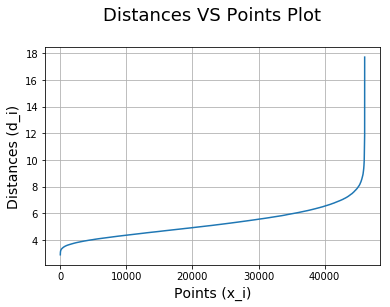

In [60]:
min_points = 2*data.shape[1]

# Computing distances of nth-nearest neighbours
distances = n_neighbour(data,min_points)
sorted_distance = np.sort(distances)
points = [i for i in range(data.shape[0])]

# Draw distances(d_i) VS points(x_i) plot
plt.plot(points, sorted_distance)
plt.xlabel('Points (x_i)',size=14)
plt.ylabel('Distances (d_i)',size=14)
plt.title('Distances VS Points Plot\n',size=18)
plt.grid()
plt.show()

In [61]:
min_points = 2*data.shape[1]
optimal_eps = 6
# Clustering with right epsilon
db1 = dbscan(optimal_eps, min_points, data)


# Clustering with  epsilon = 11
db2 = dbscan(5, min_points, data)


# Clustering with epsilon = 12
db3 = dbscan(7, min_points, data)


# Clustering with epsilon = 13
db4 = dbscan(8, min_points, data)

Number of clusters for MinPts = 100 and Epsilon = 6.000000 is : 2 
Labels(-1 is for Noise) :  {0, -1}

Number of clusters for MinPts = 100 and Epsilon = 5.000000 is : 2 
Labels(-1 is for Noise) :  {0, -1}

Number of clusters for MinPts = 100 and Epsilon = 7.000000 is : 2 
Labels(-1 is for Noise) :  {0, -1}

Number of clusters for MinPts = 100 and Epsilon = 8.000000 is : 2 
Labels(-1 is for Noise) :  {0, -1}



In [62]:

reviews = final['Text'].values
# Getting all the reviews in different clusters
cluster1 = []
cluster2 = []

for i in range(db1.labels_.shape[0]):
    if db1.labels_[i] == 0:
        cluster1.append(reviews[i])
    else :
        cluster2.append(reviews[i])
 
        
# Number of reviews in different clusters
print("No. of reviews in Cluster-1 : ",len(cluster1))
print("\nNo. of reviews in Cluster-2 : ",len(cluster2))

No. of reviews in Cluster-1 :  44330

No. of reviews in Cluster-2 :  1742


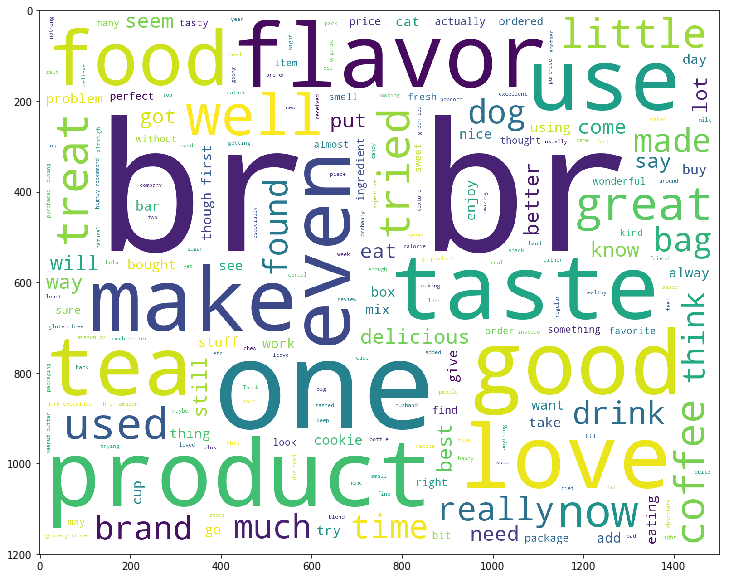

In [63]:
from wordcloud import WordCloud
wc = WordCloud(max_words=1000, margin=10, background_color='white',
               scale=3, relative_scaling = 0.5, width=500, height=400,
               random_state=1).generate(' '.join(cluster1))

plt.figure(figsize=(20,10))
plt.imshow(wc)

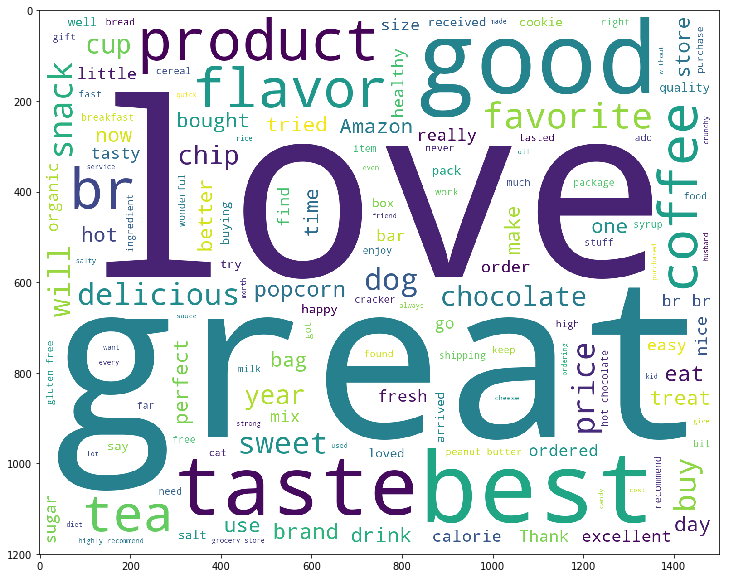

In [64]:
from wordcloud import WordCloud
wc = WordCloud(max_words=1000, margin=10, background_color='white',
               scale=3, relative_scaling = 0.5, width=500, height=400,
               random_state=1).generate(' '.join(cluster2))

plt.figure(figsize=(20,10))
plt.imshow(wc)

In [65]:
reviews = final['Text'].values
# Getting all the reviews in different clusters
cluster1 = []
cluster2 = []

for i in range(db2.labels_.shape[0]):
    if db2.labels_[i] == 0:
        cluster1.append(reviews[i])
    else :
        cluster2.append(reviews[i])
 
        
# Number of reviews in different clusters
print("No. of reviews in Cluster-1 : ",len(cluster1))
print("\nNo. of reviews in Cluster-2 : ",len(cluster2))

No. of reviews in Cluster-1 :  37528

No. of reviews in Cluster-2 :  8544


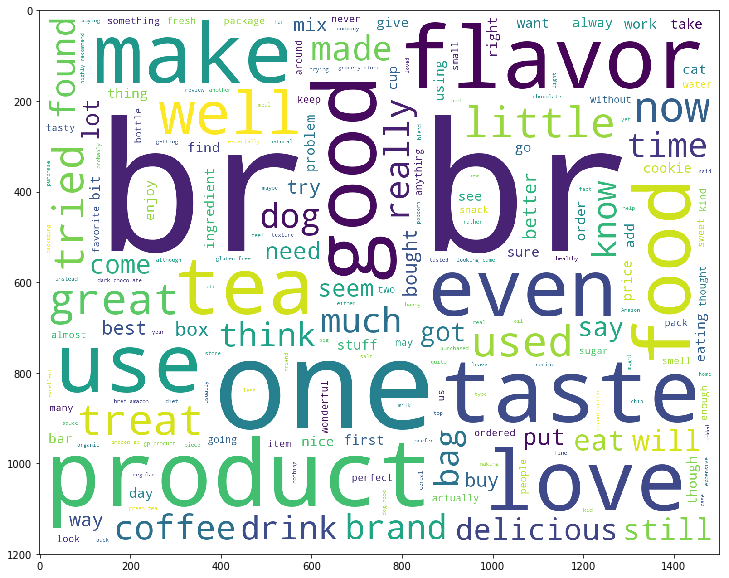

In [66]:
from wordcloud import WordCloud
wc = WordCloud(max_words=1000, margin=10, background_color='white',
               scale=3, relative_scaling = 0.5, width=500, height=400,
               random_state=1).generate(' '.join(cluster1))

plt.figure(figsize=(20,10))
plt.imshow(wc)

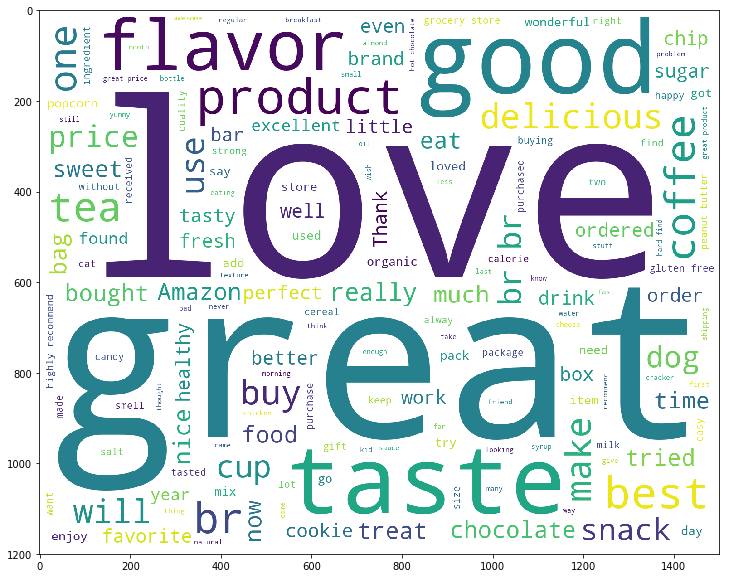

In [67]:
from wordcloud import WordCloud
wc = WordCloud(max_words=1000, margin=10, background_color='white',
               scale=3, relative_scaling = 0.5, width=500, height=400,
               random_state=1).generate(' '.join(cluster2))

plt.figure(figsize=(20,10))
plt.imshow(wc)

In [68]:
reviews = final['Text'].values
# Getting all the reviews in different clusters
cluster1 = []
cluster2 = []

for i in range(db3.labels_.shape[0]):
    if db3.labels_[i] == 0:
        cluster1.append(reviews[i])
    else :
        cluster2.append(reviews[i])
 
        
# Number of reviews in different clusters
print("No. of reviews in Cluster-1 : ",len(cluster1))
print("\nNo. of reviews in Cluster-2 : ",len(cluster2))

No. of reviews in Cluster-1 :  45797

No. of reviews in Cluster-2 :  275


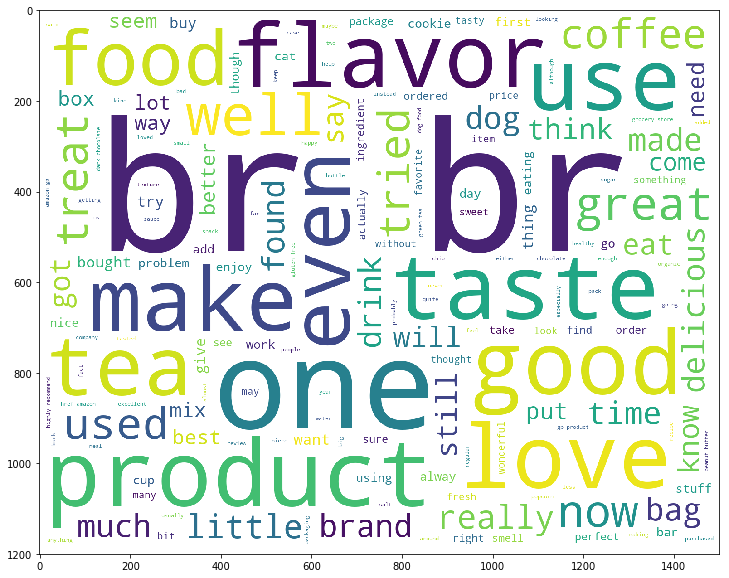

In [69]:
from wordcloud import WordCloud
wc = WordCloud(max_words=1000, margin=10, background_color='white',
               scale=3, relative_scaling = 0.5, width=500, height=400,
               random_state=1).generate(' '.join(cluster1))

plt.figure(figsize=(20,10))
plt.imshow(wc)

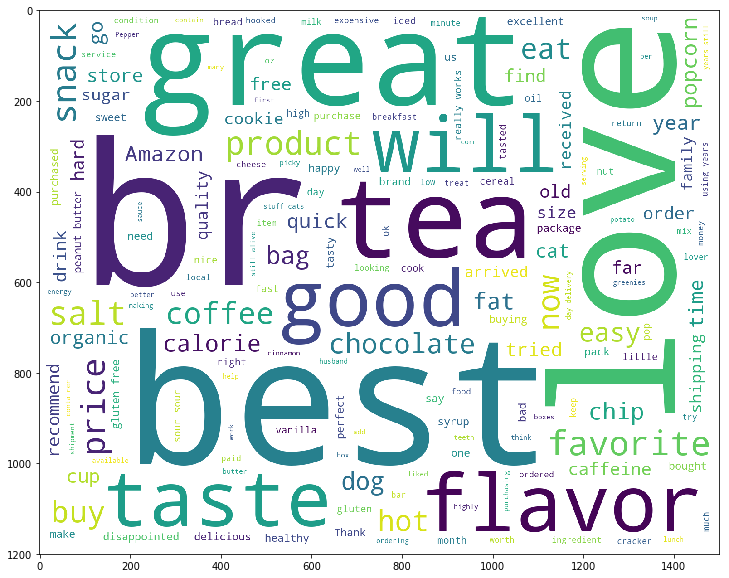

In [70]:
from wordcloud import WordCloud
wc = WordCloud(max_words=1000, margin=10, background_color='white',
               scale=3, relative_scaling = 0.5, width=500, height=400,
               random_state=1).generate(' '.join(cluster2))

plt.figure(figsize=(20,10))
plt.imshow(wc)

In [71]:
reviews = final['Text'].values
# Getting all the reviews in different clusters
cluster1 = []
cluster2 = []

for i in range(db4.labels_.shape[0]):
    if db4.labels_[i] == 0:
        cluster1.append(reviews[i])
    else :
        cluster2.append(reviews[i])
 
        
# Number of reviews in different clusters
print("No. of reviews in Cluster-1 : ",len(cluster1))
print("\nNo. of reviews in Cluster-2 : ",len(cluster2))

No. of reviews in Cluster-1 :  46036

No. of reviews in Cluster-2 :  36


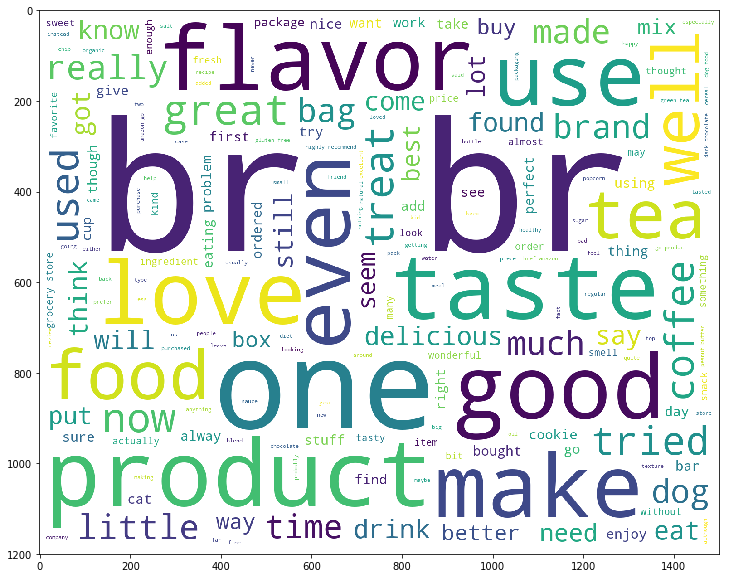

In [72]:
from wordcloud import WordCloud
wc = WordCloud(max_words=1000, margin=10, background_color='white',
               scale=3, relative_scaling = 0.5, width=500, height=400,
               random_state=1).generate(' '.join(cluster1))

plt.figure(figsize=(20,10))
plt.imshow(wc)

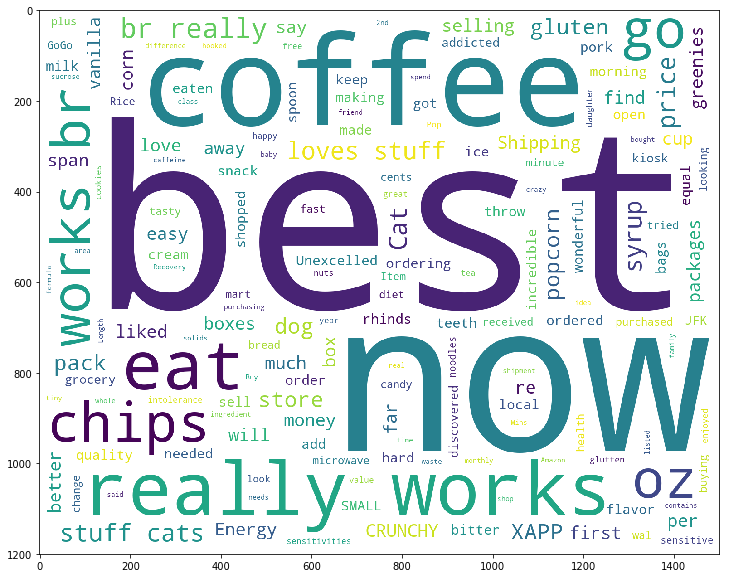

In [73]:
from wordcloud import WordCloud
wc = WordCloud(max_words=1000, margin=10, background_color='white',
               scale=3, relative_scaling = 0.5, width=500, height=400,
               random_state=1).generate(' '.join(cluster2))

plt.figure(figsize=(20,10))
plt.imshow(wc)

In [74]:
tf_idf_vect = TfidfVectorizer()
X_train = tf_idf_vect.fit_transform(x)

In [75]:
w2v_words = list(w2v_model.wv.vocab)
# TF-IDF weighted Word2Vec
tfidf_feat = tf_idf_vect.get_feature_names() # tfidf words/col-names
# final_tf_idf is the sparse matrix with row= sentence, col=word and cell_val = tfidf

model = TfidfVectorizer()
tf_idf_matrix = model.fit_transform(final['CleanedText'].values)
# we are converting a dictionary with word as a key, and the idf as a value
dictionary = dict(zip(model.get_feature_names(), list(model.idf_)))
tfidf_sent_vectors = []; # the tfidf-w2v for each sentence/review is stored in this list
row=0;
for sent in list_of_sent: # for each review/sentence
    sent_vec = np.zeros(50) # as word vectors are of zero length
    weight_sum =0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        try:
            vec = w2v_model.wv[word]
            # obtain the tf_idfidf of a word in a sentence/review
            tf_idf = dictionary[word]*(sent.count(word)/len(sent))
            sent_vec += (vec * tf_idf)
            weight_sum += tf_idf
        except:
            pass
    sent_vec /= weight_sum
    tfidf_sent_vectors.append(sent_vec)
    row += 1  

In [76]:
data = StandardScaler().fit_transform(tfidf_sent_vectors)

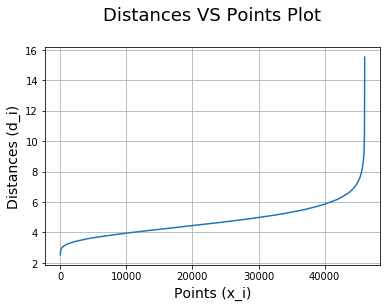

In [77]:
min_points = 2*data.shape[1]

# Computing distances of nth-nearest neighbours
distances = n_neighbour(data,min_points)
sorted_distance = np.sort(distances)
points = [i for i in range(data.shape[0])]

# Draw distances(d_i) VS points(x_i) plot
plt.plot(points, sorted_distance)
plt.xlabel('Points (x_i)',size=14)
plt.ylabel('Distances (d_i)',size=14)
plt.title('Distances VS Points Plot\n',size=18)
plt.grid()
plt.show()



In [78]:
optimal_eps = 6
# Clustering with right epsilon
db1 = dbscan(optimal_eps, min_points, data)


# Clustering with  epsilon = 11
db2 = dbscan(5, min_points, data)


# Clustering with epsilon = 12
db3 = dbscan(7, min_points, data)


# Clustering with epsilon = 13
db4 = dbscan(8, min_points, data)

Number of clusters for MinPts = 100 and Epsilon = 6.000000 is : 2 
Labels(-1 is for Noise) :  {0, -1}

Number of clusters for MinPts = 100 and Epsilon = 5.000000 is : 2 
Labels(-1 is for Noise) :  {0, -1}

Number of clusters for MinPts = 100 and Epsilon = 7.000000 is : 2 
Labels(-1 is for Noise) :  {0, -1}

Number of clusters for MinPts = 100 and Epsilon = 8.000000 is : 2 
Labels(-1 is for Noise) :  {0, -1}



In [79]:
reviews = final['Text'].values
# Getting all the reviews in different clusters
cluster1 = []
cluster2 = []

for i in range(db1.labels_.shape[0]):
    if db1.labels_[i] == 0:
        cluster1.append(reviews[i])
    else :
        cluster2.append(reviews[i])
 
        
# Number of reviews in different clusters
print("No. of reviews in Cluster-1 : ",len(cluster1))
print("\nNo. of reviews in Cluster-2 : ",len(cluster2))

No. of reviews in Cluster-1 :  45799

No. of reviews in Cluster-2 :  273


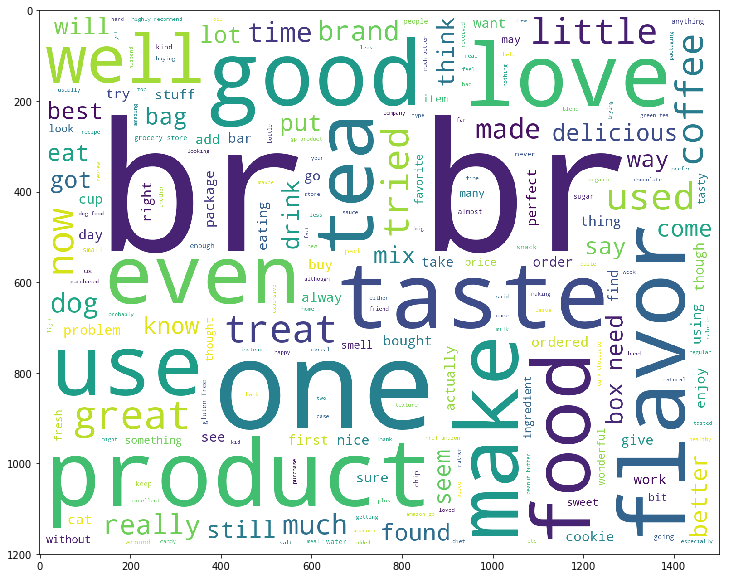

In [80]:
from wordcloud import WordCloud
wc = WordCloud(max_words=1000, margin=10, background_color='white',
               scale=3, relative_scaling = 0.5, width=500, height=400,
               random_state=1).generate(' '.join(cluster1))

plt.figure(figsize=(20,10))
plt.imshow(wc)

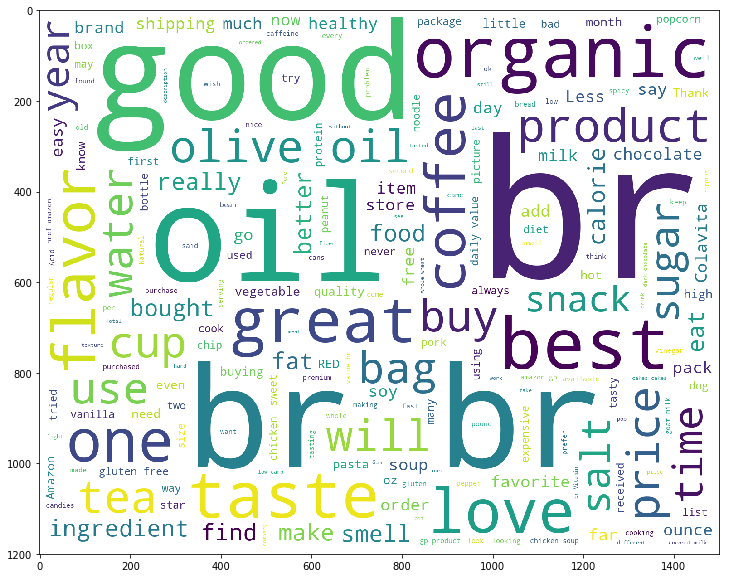

In [81]:
from wordcloud import WordCloud
wc = WordCloud(max_words=1000, margin=10, background_color='white',
               scale=3, relative_scaling = 0.5, width=500, height=400,
               random_state=1).generate(' '.join(cluster2))

plt.figure(figsize=(20,10))
plt.imshow(wc)

In [82]:
reviews = final['Text'].values
# Getting all the reviews in different clusters
cluster1 = []
cluster2 = []

for i in range(db2.labels_.shape[0]):
    if db2.labels_[i] == 0:
        cluster1.append(reviews[i])
    else :
        cluster2.append(reviews[i])
 
        
# Number of reviews in different clusters
print("No. of reviews in Cluster-1 : ",len(cluster1))
print("\nNo. of reviews in Cluster-2 : ",len(cluster2))

No. of reviews in Cluster-1 :  43497

No. of reviews in Cluster-2 :  2575


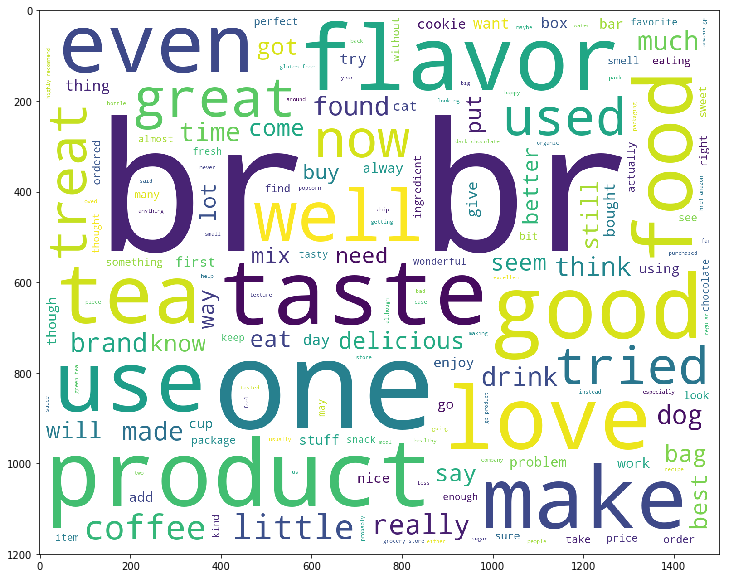

In [83]:
from wordcloud import WordCloud
wc = WordCloud(max_words=1000, margin=10, background_color='white',
               scale=3, relative_scaling = 0.5, width=500, height=400,
               random_state=1).generate(' '.join(cluster1))

plt.figure(figsize=(20,10))
plt.imshow(wc)

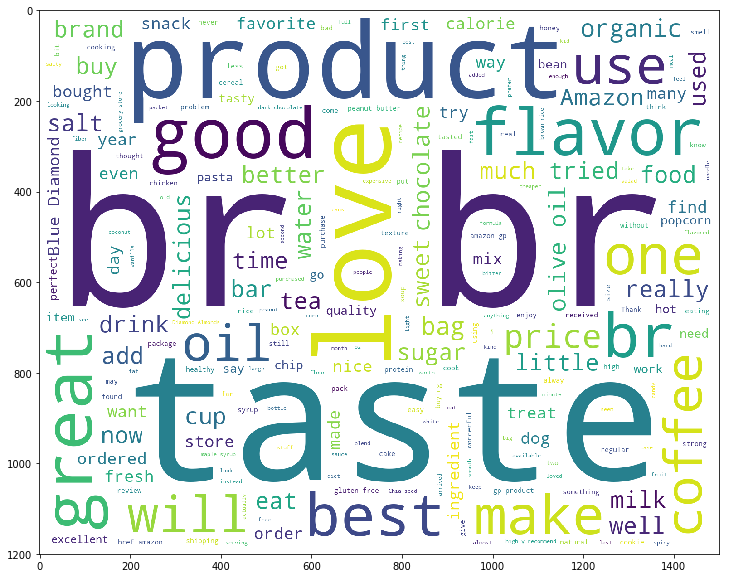

In [84]:
from wordcloud import WordCloud
wc = WordCloud(max_words=1000, margin=10, background_color='white',
               scale=3, relative_scaling = 0.5, width=500, height=400,
               random_state=1).generate(' '.join(cluster2))

plt.figure(figsize=(20,10))
plt.imshow(wc)

In [85]:
reviews = final['Text'].values
# Getting all the reviews in different clusters
cluster1 = []
cluster2 = []

for i in range(db3.labels_.shape[0]):
    if db3.labels_[i] == 0:
        cluster1.append(reviews[i])
    else :
        cluster2.append(reviews[i])
 
        
# Number of reviews in different clusters
print("No. of reviews in Cluster-1 : ",len(cluster1))
print("\nNo. of reviews in Cluster-2 : ",len(cluster2))

No. of reviews in Cluster-1 :  46044

No. of reviews in Cluster-2 :  28


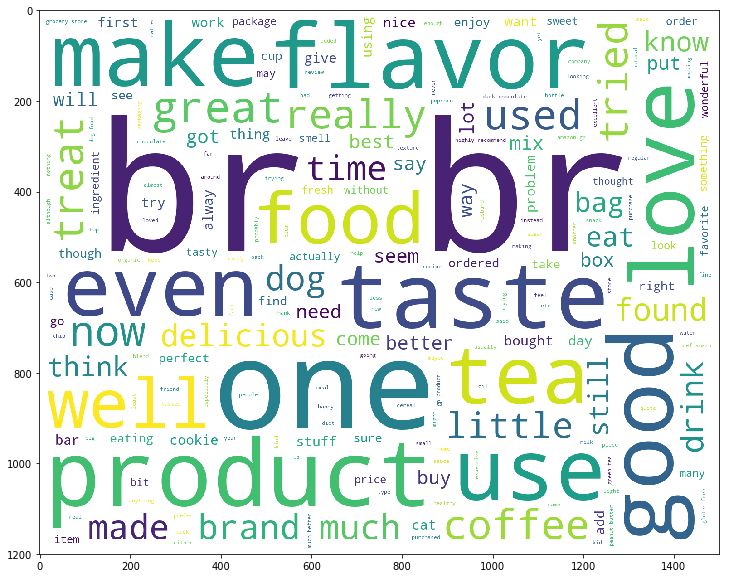

In [86]:
from wordcloud import WordCloud
wc = WordCloud(max_words=1000, margin=10, background_color='white',
               scale=3, relative_scaling = 0.5, width=500, height=400,
               random_state=1).generate(' '.join(cluster1))

plt.figure(figsize=(20,10))
plt.imshow(wc)

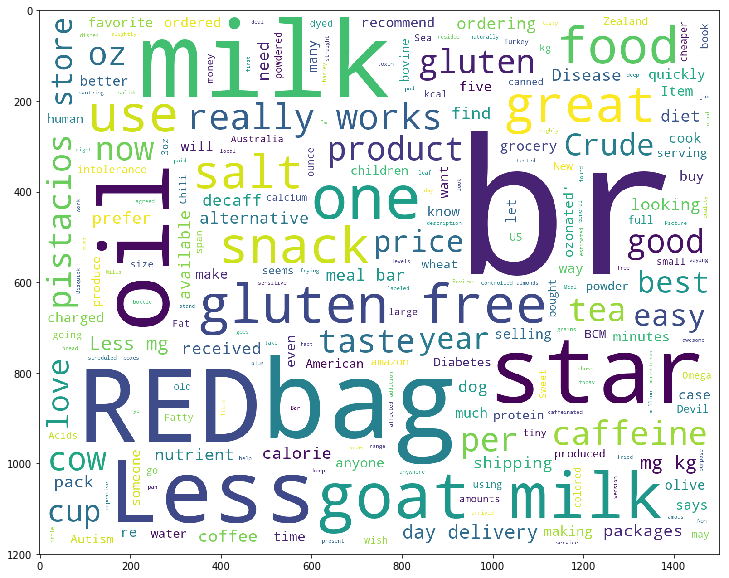

In [87]:
from wordcloud import WordCloud
wc = WordCloud(max_words=1000, margin=10, background_color='white',
               scale=3, relative_scaling = 0.5, width=500, height=400,
               random_state=1).generate(' '.join(cluster2))

plt.figure(figsize=(20,10))
plt.imshow(wc)

In [88]:
reviews = final['Text'].values
# Getting all the reviews in different clusters
cluster1 = []
cluster2 = []

for i in range(db4.labels_.shape[0]):
    if db4.labels_[i] == 0:
        cluster1.append(reviews[i])
    else :
        cluster2.append(reviews[i])
 
        
# Number of reviews in different clusters
print("No. of reviews in Cluster-1 : ",len(cluster1))
print("\nNo. of reviews in Cluster-2 : ",len(cluster2))

No. of reviews in Cluster-1 :  46067

No. of reviews in Cluster-2 :  5


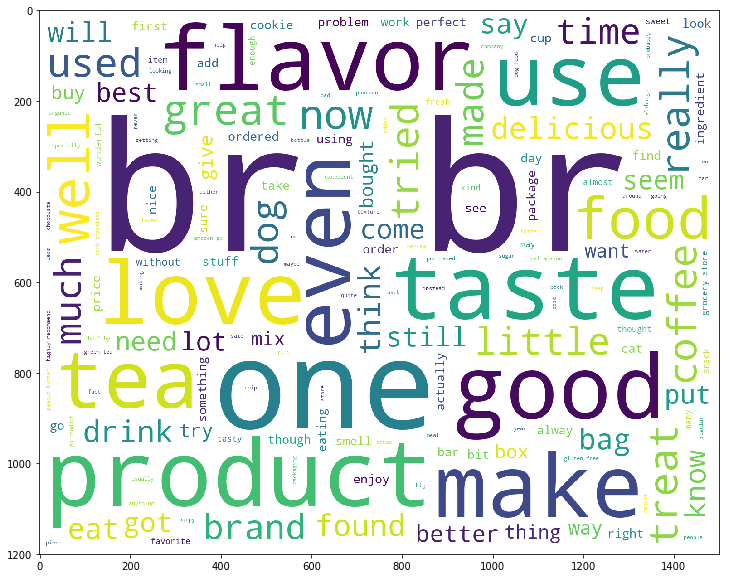

In [89]:
from wordcloud import WordCloud
wc = WordCloud(max_words=1000, margin=10, background_color='white',
               scale=3, relative_scaling = 0.5, width=500, height=400,
               random_state=1).generate(' '.join(cluster1))

plt.figure(figsize=(20,10))
plt.imshow(wc)

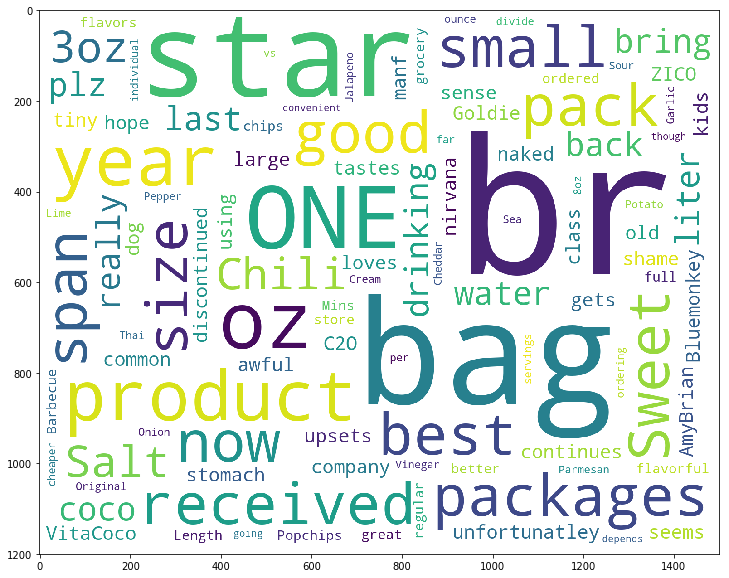

In [90]:
from wordcloud import WordCloud
wc = WordCloud(max_words=1000, margin=10, background_color='white',
               scale=3, relative_scaling = 0.5, width=500, height=400,
               random_state=1).generate(' '.join(cluster2))

plt.figure(figsize=(20,10))
plt.imshow(wc)